# Comparing Mistral 7B and Mixtral 8x7B

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [5]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [6]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [7]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [8]:
prompt = "Are any medical symptoms mentioned in the transcript"
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 0:   0%|          | 0/550 [00:00<?, ?it/s]

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 18,521:   4%|▍         | 22/550 [00:05<02:09,  4.06it/s]

## Model evaluation

Mistral7B


Bootstrapping Mistral7B: 100%|██████████| 1000/1000 [00:03<00:00, 261.51it/s]


accuracy: 0.6118 (0.5691-0.6527 95% CI)
precision: 0.6852 (0.6427-0.7273 95% CI)
recall: 0.8114 (0.7716-0.849 95% CI)
f1: 0.7428 (0.7073-0.7756 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


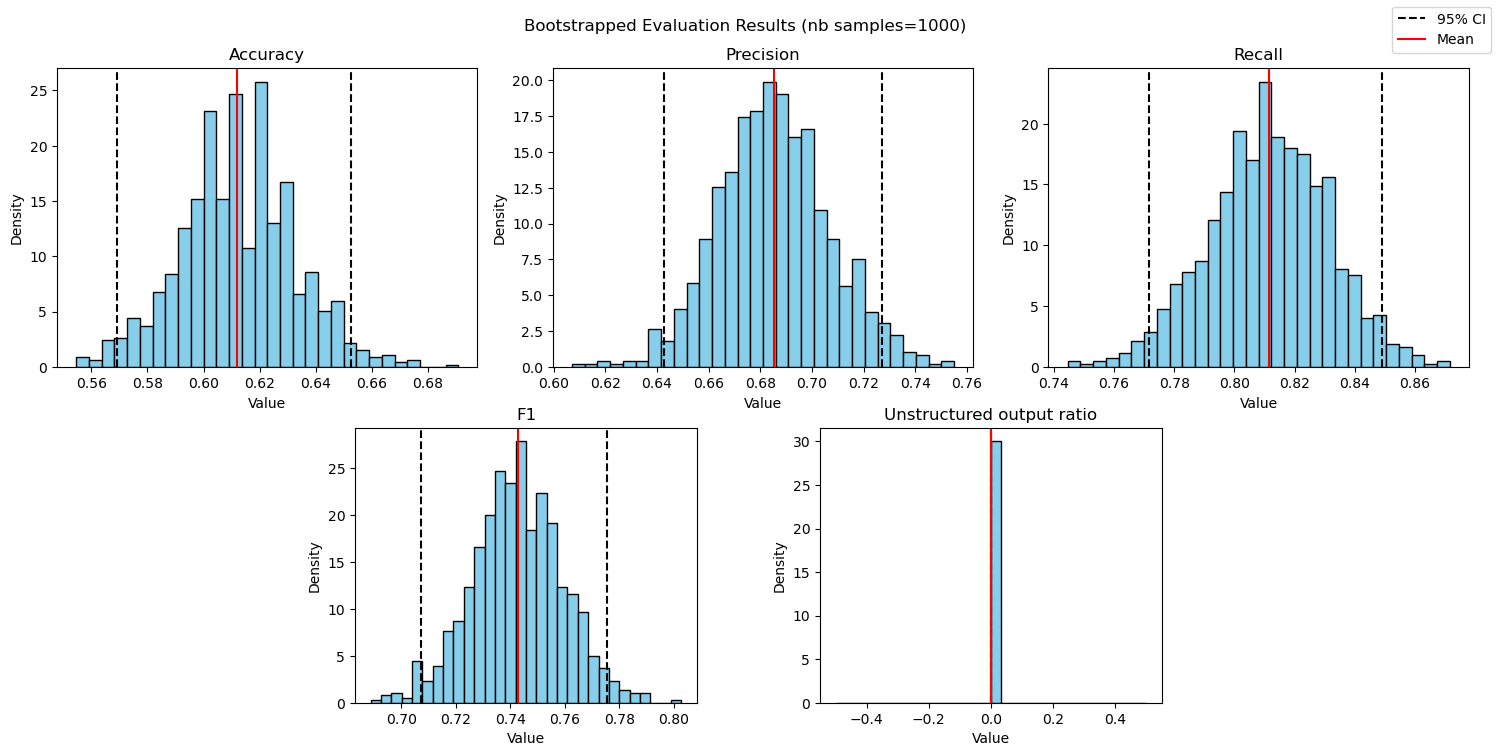

In [7]:
print("Mistral7B")
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b, model_name="Mistral7B")
scorer_mistral7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Mixtral8x7B


Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:03<00:00, 259.78it/s]


accuracy: 0.6369 (0.5982-0.6745 95% CI)
precision: 0.7452 (0.7022-0.7875 95% CI)
recall: 0.7202 (0.6723-0.7629 95% CI)
f1: 0.7323 (0.6954-0.7656 95% CI)
Unstructured output ratio: 0.0 (0.0-0.0 95% CI)


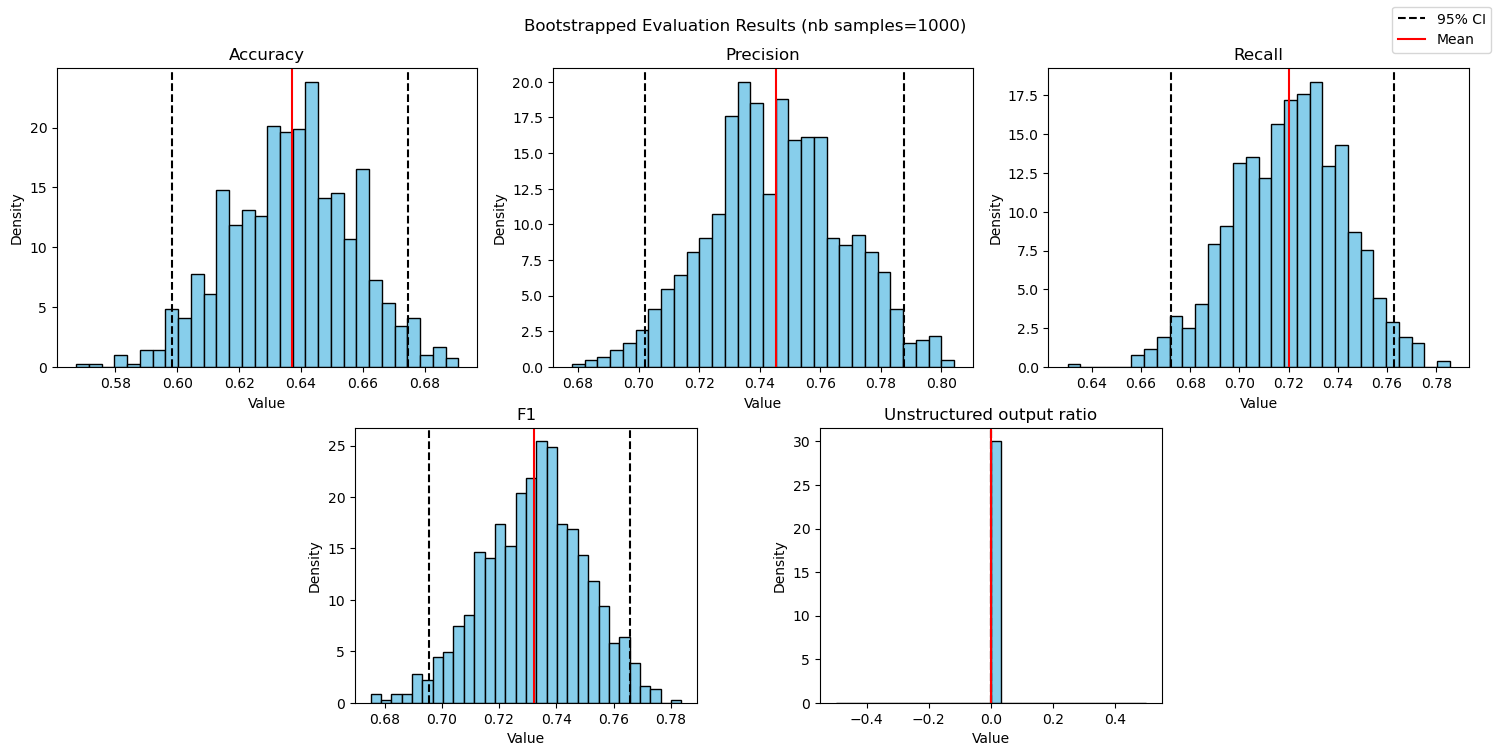

In [8]:
print("Mixtral8x7B")
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b, model_name="Mixtral8x7B")
scorer_mixtral8x7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:03<00:00, 270.98it/s]


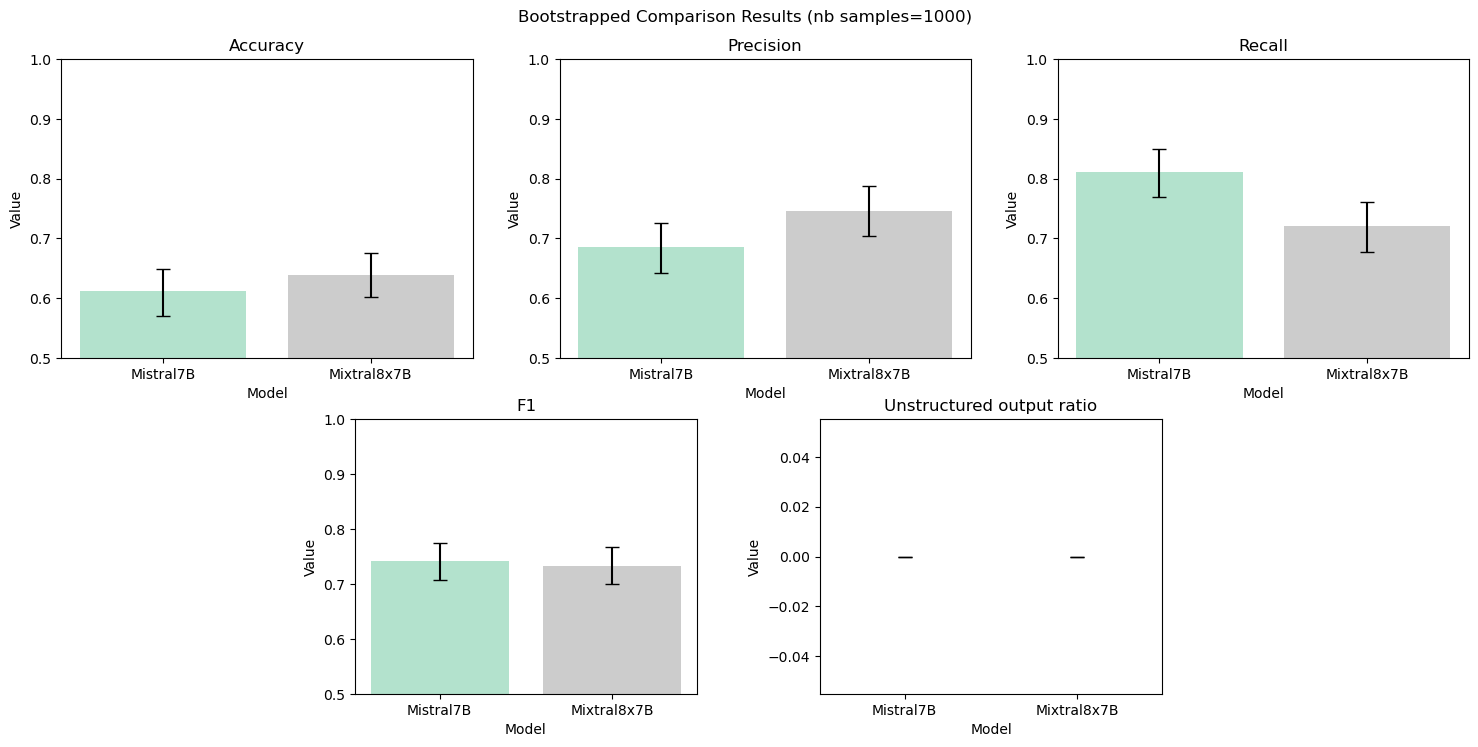

In [9]:
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [10]:
df_mistral7b_error = scorer_mistral7b.get_error_dataframe()
df_mistral8x7b_error = scorer_mixtral8x7b.get_error_dataframe()

In [11]:
selected_columns = df_mistral7b_error.columns[:df_mistral7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,214,102,38,214,214,77,214,28,28,11,214,72,214
unique,214,2,29,50,2,51,50,13,17,2,2,53,2
top,D: OK. Have you had any any headaches?\n\nP: U...,Negative,Other,MSK0019.txt,Negative,Other,MSK0019.txt,None;Other,NONE,Negative;Positive,False,other,True
freq,1,65,5,8,137,18,8,8,10,7,142,11,142


In [12]:
with pd.option_context('display.max_colwidth', None):
    print(df_mistral7b_error["Context"].head())

2                                                                                                           D: OK. Have you had any any headaches?\n\nP: Um, no headaches, no.\n\nD: OK. How about any cough?\n\nP: No cough. \n\nD: No coughing, OK. And how about any shortness of breath?\n\nP: No. \n\nD: OK, have you had any wheezing?\n\nP: No. \n\nD: How about any chest pain?\n\nP: No chest pain.\n\nD: Any fainting or dizziness? \n\nP: No.\n\nD: OK, and have you had any heart palpitations?\n\nP: Uh, no. \n\nD: OK. And so you don't you haven't had any cough, but have you had any instances of bringing up any sputum or or any blood?\n\nP: No. \n\nD: OK. And have you had any nausea or vomiting?\n\nP: No.
5                             D: OK. Uhm, and any hospitalizations or surgeries before?\n\nP: No. \n\nD: OK, uh, and uh currently, are you in, in school or working?\n\nP: I'm in school. I'm in Grade 10 and we're doing half days now.\n\nD: OK. Err, half days like in person?\n\nP: Yeah half in 

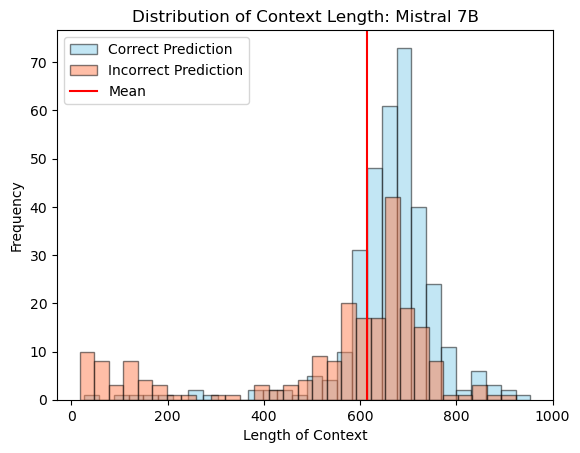

In [13]:
scorer_mistral7b.display_length_distribution("Mistral 7B")

note: there doesn't seem to be anything linked to the source given freq. Looking at the discussions, there are many instances where the patient mentions a symptom for a relative, but that doesn't apply to them. This is probably what the model catches on.

Interesting recall of 1

No NaNs

In [14]:
selected_columns = df_mistral8x7b_error.columns[:df_mistral8x7b_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"]
df_mistral8x7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status
count,198,90,52,198,198,110,198,34,34,9,198,105,198
unique,198,2,43,49,2,71,49,14,24,2,2,72,2
top,D: OK. Have you had any any headaches?\n\nP: U...,Positive,Other,RES0009.txt,Positive,Other,RES0009.txt,None;Other,NONE,Negative;Positive,True,other,False
freq,1,51,6,10,110,18,10,8,9,6,105,11,105


In [15]:
with pd.option_context('display.max_colwidth', None):
    print(df_mistral8x7b_error["Context"].head())

2                                                                                                           D: OK. Have you had any any headaches?\n\nP: Um, no headaches, no.\n\nD: OK. How about any cough?\n\nP: No cough. \n\nD: No coughing, OK. And how about any shortness of breath?\n\nP: No. \n\nD: OK, have you had any wheezing?\n\nP: No. \n\nD: How about any chest pain?\n\nP: No chest pain.\n\nD: Any fainting or dizziness? \n\nP: No.\n\nD: OK, and have you had any heart palpitations?\n\nP: Uh, no. \n\nD: OK. And so you don't you haven't had any cough, but have you had any instances of bringing up any sputum or or any blood?\n\nP: No. \n\nD: OK. And have you had any nausea or vomiting?\n\nP: No.
3                                                                    D: Have you had any abdominal pain?\n\nP: No. \n\nD: You had any diarrhea or, or constipation?\n\nP: Uh, no. \n\nD: OK. How about any urinary problems?\n\nP: Um, no, nothing like that. \n\nD: I see, OK. And any skin changes 

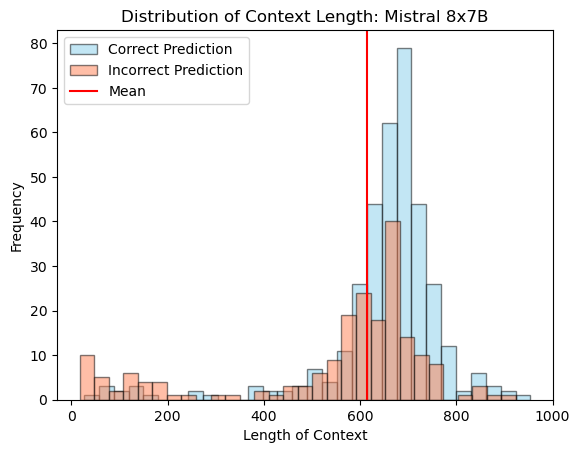

In [16]:
scorer_mixtral8x7b.display_length_distribution("Mistral 8x7B")